# Count Data and Hierarchical Modeling

In [14]:
library(tidyverse)
library(rjags)
library(COUNT)

colorblind = c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

## 10. Poisson Regression

**General Expression**

$$
y_i \mid \lambda_i \overset{ind}{\sim} Pois(\lambda_i) \ \ (i=1, \ldots, n)
$$

**Linear Regression**

$$
\mathbb{E} (y_i) = \beta_0 + \beta_1 x_{1i}
$$

**Log Link**

$$
\begin{aligned}
log(\mathbb{E}(y_i)) &= log(\lambda_i) = \beta_0 + \beta_1 x_{1i} \\[10pt]
\Rightarrow \mathbb{E} (y_i) &= \lambda_i = e^{\beta_0 + \beta_1 x_{1i}} \\[20pt]
y_i \mid x_i, \beta &\overset{ind}{\sim} Pois(exp[\beta_0 + \beta_1 x_{1, i} ] )
\end{aligned}
$$

**Comparison**

Model | Normal Regression | Poisson Regression
--|--|--
**Response** | $\mathbb{E} (y)$ | $\mathbb{E}(log(y))$
**Variance** | exists as an independent parameter | same as $\lambda$

### Modeling (JAGS)

In [13]:
data("badhealth")

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1127
   Unobserved stochastic nodes: 4
   Total graph size: 3665

Initializing model



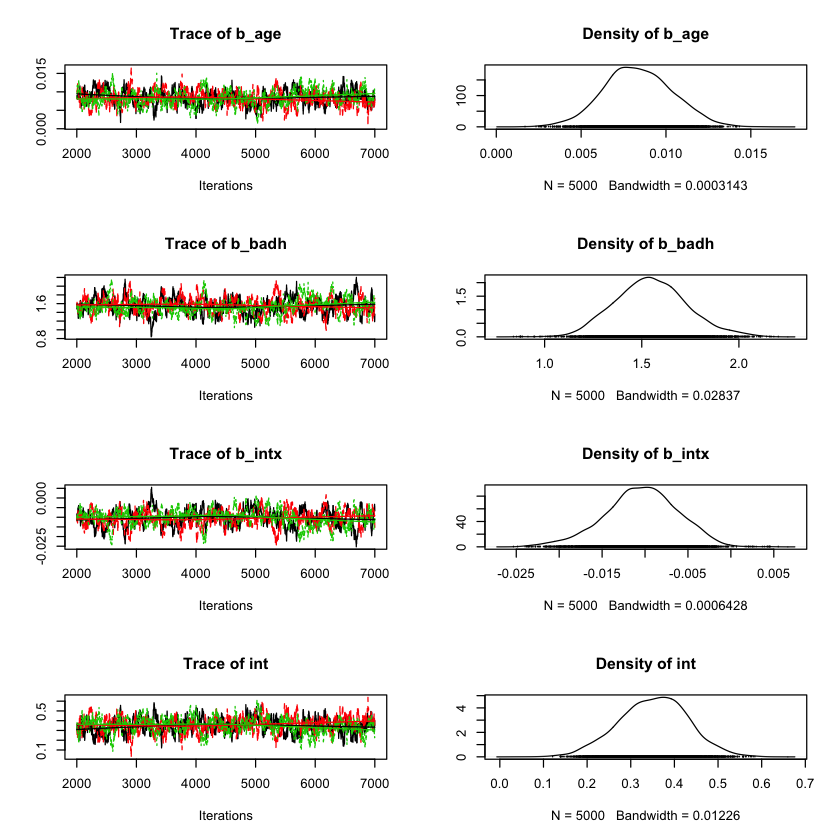

In [15]:
mod_string = " model {
  for (i in 1:length(numvisit)) {
    numvisit[i] ~ dpois(lam[i])
    log(lam[i]) = int + b_badh*badh[i] + 
      b_age*age[i] + b_intx*age[i]*badh[i]
  }

  int    ~ dnorm(0.0, 1.0/1e6)
  b_badh ~ dnorm(0.0, 1.0/1e4)
  b_age  ~ dnorm(0.0, 1.0/1e4)
  b_intx ~ dnorm(0.0, 1.0/1e4)
} "

data_jags = as.list(badhealth)
params    = c("int", "b_badh", "b_age", "b_intx")

mod = jags.model(textConnection(mod_string), data=data_jags, n.chains=3)
update(mod, 1e3)

mod_sim = coda.samples(model=mod, variable.names=params, n.iter=5e3)
mod_csim = as.mcmc(do.call(rbind, mod_sim))

plot(mod_sim)

## More) Prior Sensitivity Analysis

To increase the credibility of the results is, **repeat the analysis under a variety of priors**.

If the results are **sensitive** to the choice of prior, we have to **explain** the difference.

If the results are **insensitive** to the choice of prior, this is evidence that the **data** are strongly driving the results.

## 11. Hierarchical Modeling

### Correlated Data

Sometimes, some observation pairs **should be more similar to each other** than to others.

The observations are conditionally independent, given their **respective group parameters**.

But grouped observations share **common parameters**, which themselves share a **common distribution** across groups.

### Example

150 test cookies, 30 each of 5 locations

**Fully independent**

$$
y_i \mid \lambda \overset{iid}{\sim} Pois(\lambda) \ \ (i=1,\ldots, 150)
$$

**Location independent**

$$
\begin{aligned}
y_i \mid l_i, \lambda_{l_i} &\overset{ind}{\sim} Pois(\lambda_{l_i}) 
\begin{cases}
l_i \in \{1, \ldots, 5\} \\
i = 1, \ldots, 150 
\end{cases} \\[15pt]
\lambda_l \mid \alpha, \beta &\overset{iid}{\sim} Gamma(\alpha, \beta) \ \ (l=1, \ldots, 5)\\[15pt]
\alpha &\sim p(\alpha), \ \ \beta \sim p(\beta) \\
\end{aligned}
$$

In [8]:
cookies = read.table(file="cookies.txt", header=TRUE)
cookies$location = as.factor(cookies$location)

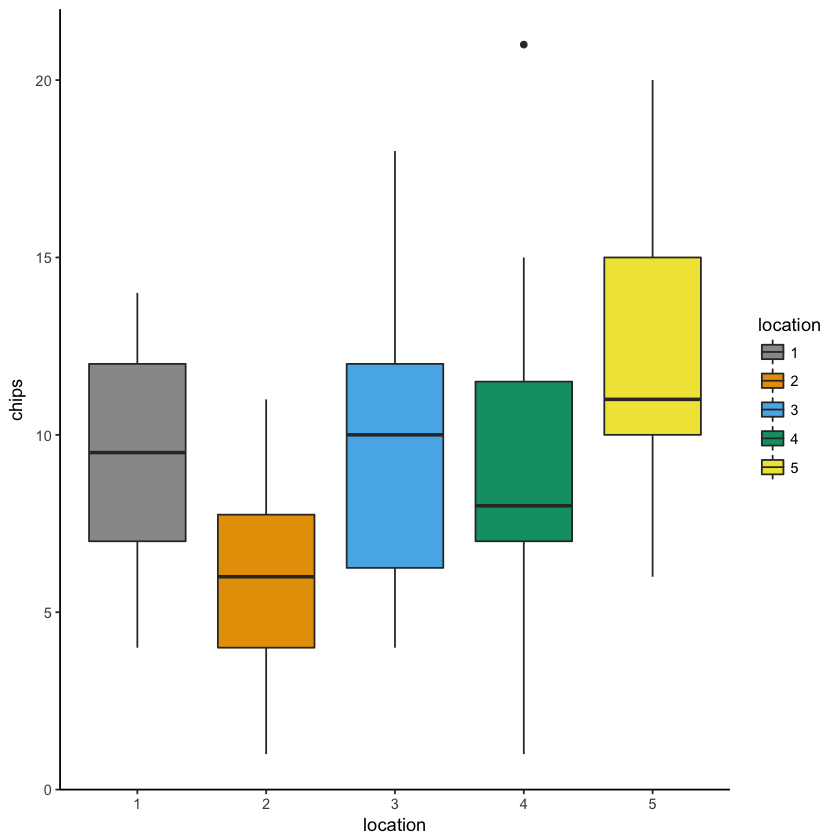

In [10]:
ggplot(cookies, aes(x=location, y=chips, fill=location)) +
    geom_boxplot() +
    scale_fill_manual(values=colorblind) +
    theme_classic()

### Modeling and Checking (JAGS)

**Observation Level Residual($y_i - \lambda_{l_i}$)**

**Location Mean Level Residual($\lambda_{l_i} - \lambda$)**

## More) Mixture Models

If we only have the data values themselves and no covariates, we might have to fit a **non-standard distribution** to the data.

(Sometimes, mixture models are susceptible to **identifiability problem**.)

**General Expression for the Discrete Mixture of Distributions**

$$
p(y) = \sum_{j=1}^J \omega_j \cdot f_j(y)
$$

**Bayesian Inference for Mixture Models**

$$
\begin{aligned}
yi∣zi,
θPr(zi=j∣ω)ωθ∼indfzi(y∣θ),i=1,…,n=ωj,j=1,…,J∼p(ω)∼p(θ)
\end{aligned}
$$

**Dirichlet Prior**

If $\theta$ has a $Dirichlet(\alpha_1, \ldots, \alpha_K)$ **prior**,

and the counts of **multinomial data** in each category are $x_1, \ldots, x_K$ (i.e., data sample size $= \sum_{k=1}^K x_K$),

then the **posterior** of $\theta$ is $Dirichlet(\alpha_1 + x_1, \ldots, \alpha_K + x_K)$.

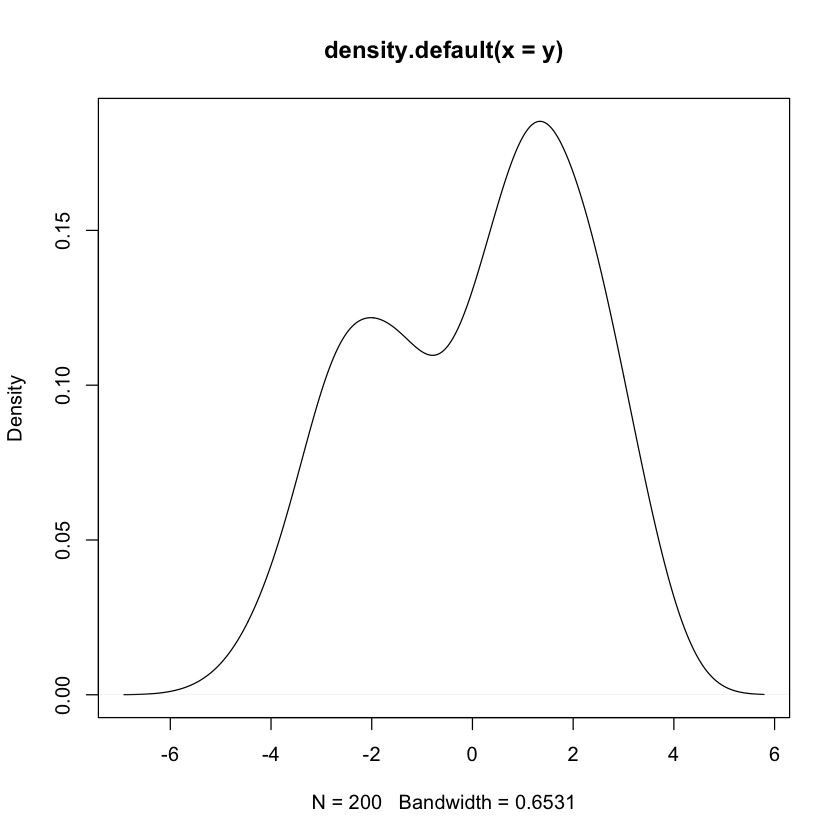

In [16]:
mixture = read.csv("mixture.csv", header=FALSE)
y = mixture$V1
plot(density(y))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 204
   Total graph size: 614

Initializing model



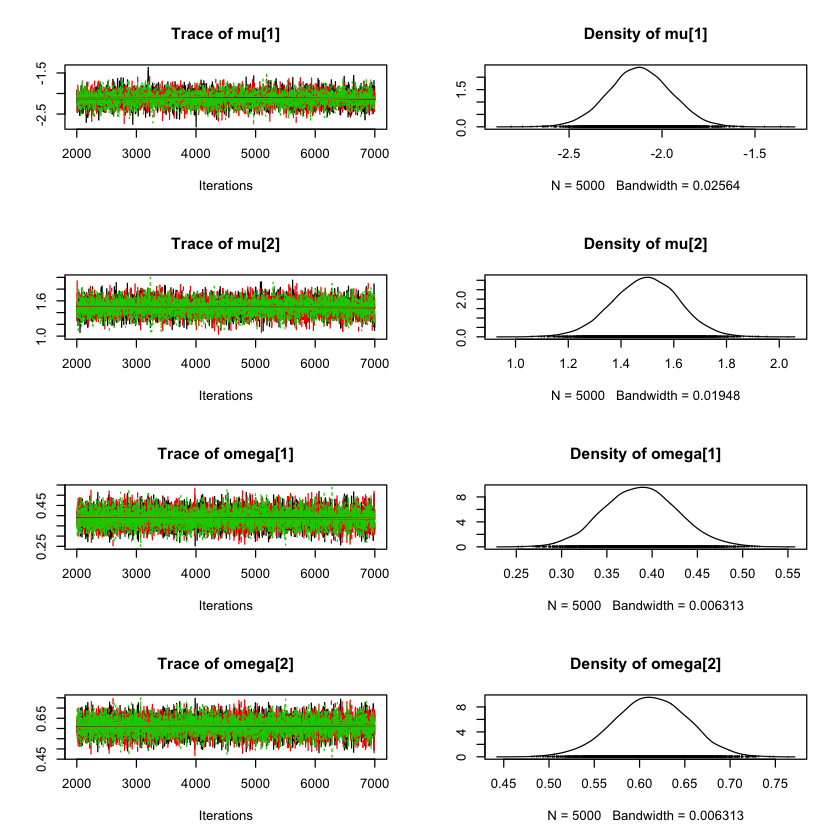

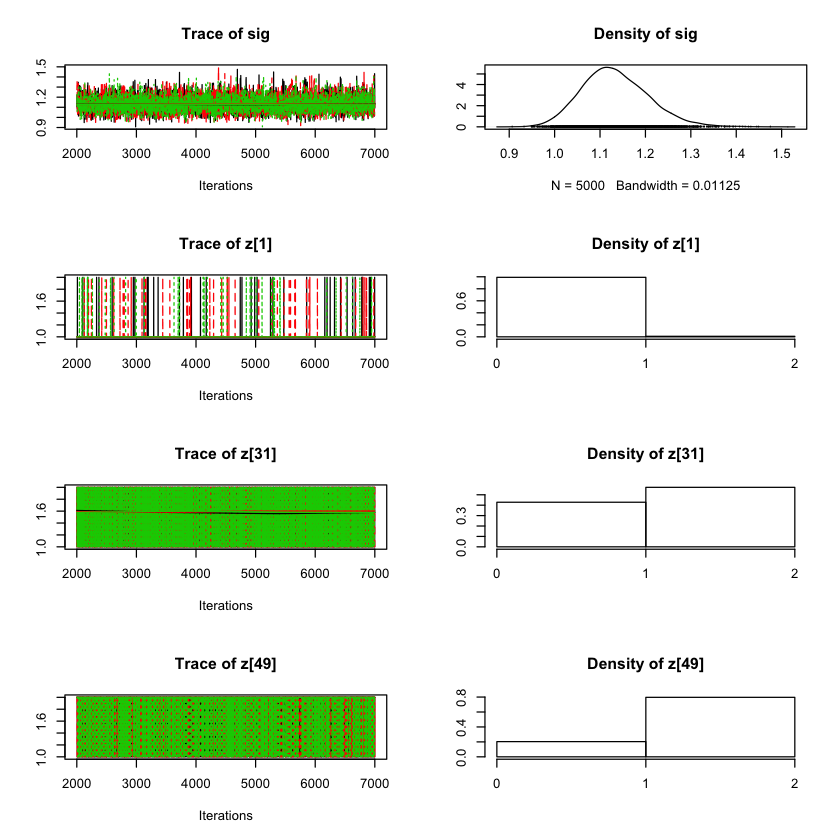

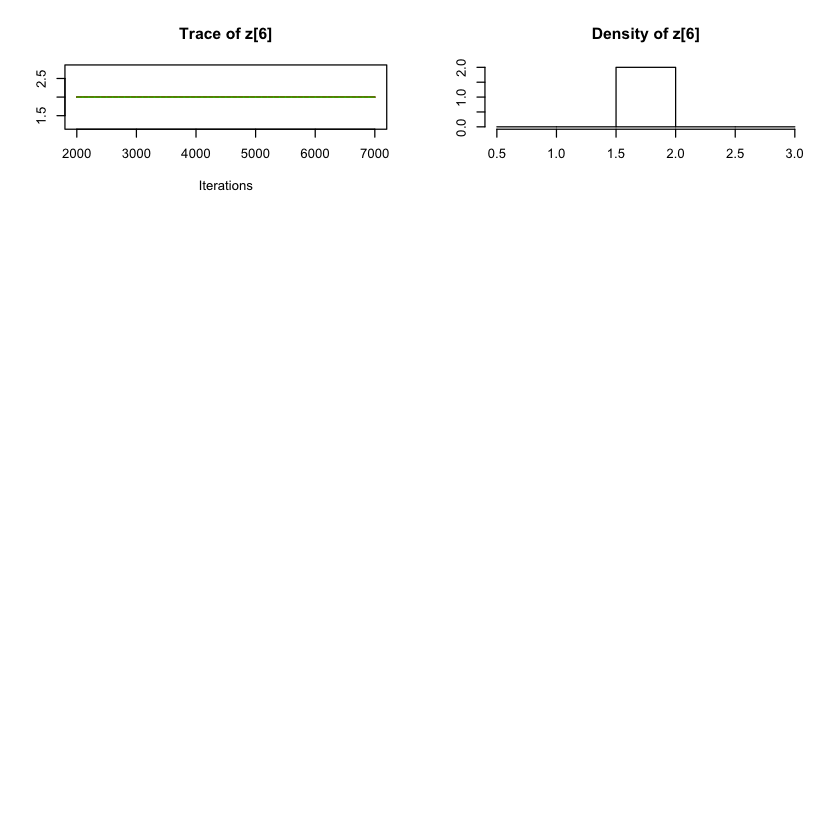

In [17]:
mod_string = " model {
for (i in 1:length(y)) {
  y[i] ~ dnorm(mu[z[i]], prec)
  z[i] ~ dcat(omega)
}

mu[1] ~ dnorm(-1.0, 1.0/100.0)
mu[2] ~ dnorm(1.0, 1.0/100.0) T(mu[1],) 

prec ~ dgamma(1.0/2.0, 1.0*1.0/2.0)
sig = sqrt(1.0/prec)

omega ~ ddirich(c(1.0, 1.0))
} "

data_jags = list(y=y)

params = c("mu", "sig", "omega", "z[1]", "z[31]", "z[49]", "z[6]")

mod = jags.model(textConnection(mod_string), data=data_jags, n.chains=3)
update(mod, 1e3)

mod_sim = coda.samples(model=mod,
                       variable.names=params,
                       n.iter=5e3)
mod_csim = as.mcmc(do.call(rbind, mod_sim))

plot(mod_sim)